In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import os
from glob import glob
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from statsmodels.api import GLM, families
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
# Mostrar todas las columnas y mejor formato de floats
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format

In [3]:
# Ruta carpeta
ruta_base = "/Users/juansierra/Desktop/casos aplicados/proyecto final/AGUA"
archivos_parquet = sorted(glob(os.path.join(ruta_base, "*.parquet")))

In [4]:
# Leer el primer archivo
df_ref = pd.read_parquet(archivos_parquet[0])
columnas_ref = df_ref.columns.tolist()
tipos_ref = df_ref.dtypes

# Lista para acumular los df
df_list = [df_ref]

# Revisar los demás archivos
for archivo in archivos_parquet[1:]:
    df_temp = pd.read_parquet(archivo)
    
    # Validar columnas
    if list(df_temp.columns) != columnas_ref:
        print(f"Columnas distintas en: {archivo}")
        print("Esperadas:", columnas_ref)
        print("Encontradas:", list(df_temp.columns))
        continue
    
    # Validar tipos de datos
    if not df_temp.dtypes.equals(tipos_ref):
        print(f"Tipos diferentes en: {archivo}")
        print(df_temp.dtypes.compare(tipos_ref))
        continue

    # agregar a la lista si esta ok
    df_list.append(df_temp)

# Concatenar solo los archivos válidos
df = pd.concat(df_list, ignore_index=True)
print(f"Archivos concatenados: {len(df_list)} archivos")
print("Shape final:", df.shape)

Archivos concatenados: 5 archivos
Shape final: (928475, 681)


In [5]:
df

,AGRUPAGENTE,Altitud,antigedif,antigref,ANTIGUEDAD_VIVIENDA,anualidad_reemplazo,anualidad_seguro,AnyoCons_edif,AnyoCons_edif_total,AUX,bloqueo,CANAL,catage_emp,catage_glob,catage_hog,catage_tur,CATTAG,cl_cobro,codigo_grp,CODINE,CODPOST,CODPROV,COMESP,CONFCOMELE,Contr_Agr_pct,Contr_Cons_pct,Contr_ConvIndefH_pct,Contr_ConvIndefm_pct,Contr_Ind_pct,Contr_IndefH_pct,Contr_IndefM_pct,Contr_Serv_pct,Contr_TempH_pct,Contr_Tempm_pct,Contr_tot_pct,Conv_AVG,CORINE_VARIETY,CUPD_CAP_Corr_aguaacagbc,CUPD_Exc_aguaacagbc,DC,densidad_cpost,DIAS_PREC_SUP_10MM,DIAS_PREC_SUP_1MM,DIAS_PREC_SUP_30MM,DIAS_VIENT_MAX_60KMH,DIAS_VIENT_MAX_70KMH,DIAS_VIENT_MAX_80KMH,DIAS_VIENT_MED_30KMH,DIAS_VIENT_MED_40KMH,DIAS_VIENT_MED_50KMH,DIST_COAST,Duracion_per_calido,Duracion_per_seco,edadtom,Elevation_AVG,EMSU_RISK,EQ_AVG,EQ_RISK,ERA5_Daily_avg_u,Etiq_AGUAACAGBC,ETP_anual,EU_IMP_IBU_100m,EU_IMP_IBU_10m,EU_IMP_IMD_100m,EU_IMP_IMD_10m,EU_LC_L1,EU_LC_L2,EU_TOPO_ASP_D4,EU_TOPO_ASP_D8,EU_TOPO_CONV,EU_TOPO_DIST_COAST,EU_TOPO_ELE,EU_TOPO_HAND,EU_TOPO_SLO,EU_VEG_FTY_100m,EU_VEG_FTY_10m,EU_VEG_TCD_100m,EU_VEG_TCD_10m,exp_corr_ACAGBC,EXPOSICION,extension,Factor_R,FI_RISK,Flood_AVG,FLRF_RISK,FLSW_RISK,FP,GMSeguros_indice_med,HA_RISK,HABITANTES,Hail_AVG,IMP_GMIS,Imperv_AVG,Ind_Turc_Regadio,Ind_Turc_Secano,K_ACAGBC,Landslide_AVG,LC_100m,LC_10m,MediadorLMI,mediaEdad,NIF_TIPO,NP_RB,nse,num_declaraciones,num_habitantes,p_africa,p_agpA,p_agpB,p_ALEM,p_americana,p_arabian,P_ARABIAN_VS_TOT,p_consF,p_cpers,p_dpers,p_east_EUR,P_EAST_EUR_VS_TOT,p_espa,p_extra,P_EXTRA_RESTO,p_induC,p_induD,p_induE,p_mcpers,p_p0004,p_p0019,p_p0509,p_p100M,p_p1014,p_p1519,p_p2024,p_p2039,p_p2529,p_p3034,p_p3539,p_p4044,p_p4064,p_p4549,p_p5054,p_p5559,p_p6064,p_p6569,p_p65M,p_p7074,p_p7579,p_p8084,p_p8589,p_p9094,p_p9599,p_portales_A,p_portales_B,p_portales_C,p_portales_D,p_portales_E,p_portales_F,p_portales_NA,p_servG,p_servH,p_servI,p_servJ,p_servK,p_servL,p_servM,p_servN,p_servO,p_servP,p_servQ,P_SUDAMER_VS_TOT,p_tpers,p_UE27,p_upers,p_WEST_EUR,P_WEST_EUR_VS_TOT,PACRAS,Paro_0024_pct,Paro_2544_pct,Paro_Agr_pct,Paro_Cons_pct,Paro_Dese_pct,Paro_Ind_pct,Paro_tot_pct,PCT_CLIENTE_AP,PCT_DTO_COMERCIAL,PCT_DTO_COMISION_AGENTE,PCT_DTO_TRASPASO,pct1524Tot,pct2544Tot,pctActTot,pctJovenTot,pctJubiladoTot,pctM45Tot,Pluviometria_anual,pob_1524Tot,pob_2544Tot,pob_actTot,pob_JovenTot,pob_JubiladoTot,pob_M45Tot,pob_Total,POL_ACCIDENTES,POL_AHORRO,POL_AUTOS,POL_COL_AHORRO,POL_COL_PENSIONES,POL_COL_RIESGO,POL_COMERCIO,POL_COMUNIDADES,POL_EMPRESAS,POL_FLOTAS,POL_HOGAR,POL_IND_AHORRO,POL_IND_FINANCIERO,POL_IND_PENSIONES,POL_IND_RIESGO,POL_MOTOS,POL_NO_VIDA,POL_NOAUTOS,POL_PATRIMONIALES,POL_PENSIONES,POL_RIESGO,POL_SALUD,POL_TOTAL,POL_TURISMOS,POL_VEH_COMERCIAL,POL_VIDA,POLAGE_ACCIDENTES,POLAGE_AUTOS,POLAGE_COMERCIO,POLAGE_COMUNIDADES,POLAGE_FLOTAS,POLAGE_HOGAR,POLAGE_MOTOS,POLAGE_NO_VIDA,POLAGE_NOAUTOS,POLAGE_TURISMOS,POLAGE_VEH_COMERCIAL,POP_GHS2015,POP_GPW2020,Population_AVG,PREC_E_OBS_100Y,PREC_E_OBS_10Y,PREC_E_OBS_25Y,PREC_E_OBS_50Y,PREC_E_OBS_5Y,PREC_ECAD_100Y,PREC_ECAD_10Y,PREC_ECAD_25Y,PREC_ECAD_50Y,PREC_ECAD_5Y,PREC_ERA5_100Y,PREC_ERA5_10Y,PREC_ERA5_25Y,PREC_ERA5_50Y,PREC_ERA5_5Y,PROPIETARIO,RAMO,ratDecl_Conjuntas,ratDecl_xHab,ratTitulares_xHab,renta_bruta,renta_bruta_media,renta_disponible,ROBINSON,SC_RISK,Slope_AVG,stro_1a_AGUAACAGBC,stro_2a_AGUAACAGBC,stro_3a_AGUAACAGBC,stro_4a_AGUAACAGBC,stro_5a_AGUAACAGBC,stro_Corr_AGUAACAGBC,Stro_G_aguaacagbc,SUPERFICIE,TAG,TC_RISK,TEMP_MAX_10Y,TEMP_MAX_30Y,TEMP_MAX_50Y,TEMP_MIN_10Y,TEMP_MIN_30Y,TEMP_MIN_50Y,Temperatura_med_anual,Temperatura_med_max_mes_calido,Temperatura_med_min_mes_frio,tipoImpositivoMedio,titulares,Tornado_AVG,tot_pob,Tree_cover_AVG,VEG_TCD,VIGILANCIA,Wind_AVG,WIND_GUST_10Y,WIND_GUST_30Y,WIND_GUST_50Y,WIND_MAX_10Y,WIND_MAX_30Y,WIND_MAX_50Y,WIND_MEAN_10Y,WIND_MEAN_30Y,WIND_MEAN_50Y,WS_RISK,year,aeropuertos,agricultural_mainland,agua,altura_mea,altura_std,arrozales,Arsenico_invier,Arsenico_otono,Arsenico_primav,Arsenico_verano,Benzo_invier,Benzo_otono,Benz

In [6]:
# diccionario de datos
dict_path = os.path.join(ruta_base, "/Users/juansierra/Desktop/casos aplicados/proyecto final/data_dict.xlsx")
dic = pd.read_excel(dict_path)

In [7]:
dic

,Factores,NUMERICA,ORDINAL,CONTINUA,DISCRETA,LABEL,CATEGORÍA,MISSING,format
0,AGRUPAGENTE,1,0.00,0,1.00,Agrupacion del agente,03.Agente,True,FMT_AGRUPAGENTE
1,Altitud,1,1.00,0,1.00,Altitud (m),06.Geográfica,True,FMT_Altitud
2,antigedif,1,1.00,0,1.00,Antiguedad del edificio,04.Riesgo,True,FMT_antigedif
3,antigref,1,1.00,0,1.00,Antiguedad de la reforma,04.Riesgo,True,FMT_antigref
4,ANTIGUEDAD_VIVIENDA,1,1.00,0,1.00,Antiguedad de la vivienda (new),04.Riesgo,True,FMT_ANTIGUEDAD_VIVIENDA
...,...,...,...,...,...,...,...,...,...
676,zonas_hume,1,1.00,0,1.00,zonas_hume,08. Externas _2,True,FMT_zonas_hume
677,zonas_industriales_o_comerciales,1,1.00,0,1.00,zonas_industriales_o_comerciales,08. Externas _2,True,FMT_zonas_industriales_o_comerciales
678,zonas_portuarias,1,1.00,0,1.00,zonas_portuarias,08. Externas _2,True,FMT_zonas_portuarias
679,zonas_quemadas,1,1.00,0,1.00,zonas_quemadas,08. Externas _2,True,FMT_zonas_quemadas


In [8]:
df = df[df['exp_corr_ACAGBC']>0]
df['frecuencia'] = df['stro_Corr_AGUAACAGBC']/df['exp_corr_ACAGBC']
df

,AGRUPAGENTE,Altitud,antigedif,antigref,ANTIGUEDAD_VIVIENDA,anualidad_reemplazo,anualidad_seguro,AnyoCons_edif,AnyoCons_edif_total,AUX,bloqueo,CANAL,catage_emp,catage_glob,catage_hog,catage_tur,CATTAG,cl_cobro,codigo_grp,CODINE,CODPOST,CODPROV,COMESP,CONFCOMELE,Contr_Agr_pct,Contr_Cons_pct,Contr_ConvIndefH_pct,Contr_ConvIndefm_pct,Contr_Ind_pct,Contr_IndefH_pct,Contr_IndefM_pct,Contr_Serv_pct,Contr_TempH_pct,Contr_Tempm_pct,Contr_tot_pct,Conv_AVG,CORINE_VARIETY,CUPD_CAP_Corr_aguaacagbc,CUPD_Exc_aguaacagbc,DC,densidad_cpost,DIAS_PREC_SUP_10MM,DIAS_PREC_SUP_1MM,DIAS_PREC_SUP_30MM,DIAS_VIENT_MAX_60KMH,DIAS_VIENT_MAX_70KMH,DIAS_VIENT_MAX_80KMH,DIAS_VIENT_MED_30KMH,DIAS_VIENT_MED_40KMH,DIAS_VIENT_MED_50KMH,DIST_COAST,Duracion_per_calido,Duracion_per_seco,edadtom,Elevation_AVG,EMSU_RISK,EQ_AVG,EQ_RISK,ERA5_Daily_avg_u,Etiq_AGUAACAGBC,ETP_anual,EU_IMP_IBU_100m,EU_IMP_IBU_10m,EU_IMP_IMD_100m,EU_IMP_IMD_10m,EU_LC_L1,EU_LC_L2,EU_TOPO_ASP_D4,EU_TOPO_ASP_D8,EU_TOPO_CONV,EU_TOPO_DIST_COAST,EU_TOPO_ELE,EU_TOPO_HAND,EU_TOPO_SLO,EU_VEG_FTY_100m,EU_VEG_FTY_10m,EU_VEG_TCD_100m,EU_VEG_TCD_10m,exp_corr_ACAGBC,EXPOSICION,extension,Factor_R,FI_RISK,Flood_AVG,FLRF_RISK,FLSW_RISK,FP,GMSeguros_indice_med,HA_RISK,HABITANTES,Hail_AVG,IMP_GMIS,Imperv_AVG,Ind_Turc_Regadio,Ind_Turc_Secano,K_ACAGBC,Landslide_AVG,LC_100m,LC_10m,MediadorLMI,mediaEdad,NIF_TIPO,NP_RB,nse,num_declaraciones,num_habitantes,p_africa,p_agpA,p_agpB,p_ALEM,p_americana,p_arabian,P_ARABIAN_VS_TOT,p_consF,p_cpers,p_dpers,p_east_EUR,P_EAST_EUR_VS_TOT,p_espa,p_extra,P_EXTRA_RESTO,p_induC,p_induD,p_induE,p_mcpers,p_p0004,p_p0019,p_p0509,p_p100M,p_p1014,p_p1519,p_p2024,p_p2039,p_p2529,p_p3034,p_p3539,p_p4044,p_p4064,p_p4549,p_p5054,p_p5559,p_p6064,p_p6569,p_p65M,p_p7074,p_p7579,p_p8084,p_p8589,p_p9094,p_p9599,p_portales_A,p_portales_B,p_portales_C,p_portales_D,p_portales_E,p_portales_F,p_portales_NA,p_servG,p_servH,p_servI,p_servJ,p_servK,p_servL,p_servM,p_servN,p_servO,p_servP,p_servQ,P_SUDAMER_VS_TOT,p_tpers,p_UE27,p_upers,p_WEST_EUR,P_WEST_EUR_VS_TOT,PACRAS,Paro_0024_pct,Paro_2544_pct,Paro_Agr_pct,Paro_Cons_pct,Paro_Dese_pct,Paro_Ind_pct,Paro_tot_pct,PCT_CLIENTE_AP,PCT_DTO_COMERCIAL,PCT_DTO_COMISION_AGENTE,PCT_DTO_TRASPASO,pct1524Tot,pct2544Tot,pctActTot,pctJovenTot,pctJubiladoTot,pctM45Tot,Pluviometria_anual,pob_1524Tot,pob_2544Tot,pob_actTot,pob_JovenTot,pob_JubiladoTot,pob_M45Tot,pob_Total,POL_ACCIDENTES,POL_AHORRO,POL_AUTOS,POL_COL_AHORRO,POL_COL_PENSIONES,POL_COL_RIESGO,POL_COMERCIO,POL_COMUNIDADES,POL_EMPRESAS,POL_FLOTAS,POL_HOGAR,POL_IND_AHORRO,POL_IND_FINANCIERO,POL_IND_PENSIONES,POL_IND_RIESGO,POL_MOTOS,POL_NO_VIDA,POL_NOAUTOS,POL_PATRIMONIALES,POL_PENSIONES,POL_RIESGO,POL_SALUD,POL_TOTAL,POL_TURISMOS,POL_VEH_COMERCIAL,POL_VIDA,POLAGE_ACCIDENTES,POLAGE_AUTOS,POLAGE_COMERCIO,POLAGE_COMUNIDADES,POLAGE_FLOTAS,POLAGE_HOGAR,POLAGE_MOTOS,POLAGE_NO_VIDA,POLAGE_NOAUTOS,POLAGE_TURISMOS,POLAGE_VEH_COMERCIAL,POP_GHS2015,POP_GPW2020,Population_AVG,PREC_E_OBS_100Y,PREC_E_OBS_10Y,PREC_E_OBS_25Y,PREC_E_OBS_50Y,PREC_E_OBS_5Y,PREC_ECAD_100Y,PREC_ECAD_10Y,PREC_ECAD_25Y,PREC_ECAD_50Y,PREC_ECAD_5Y,PREC_ERA5_100Y,PREC_ERA5_10Y,PREC_ERA5_25Y,PREC_ERA5_50Y,PREC_ERA5_5Y,PROPIETARIO,RAMO,ratDecl_Conjuntas,ratDecl_xHab,ratTitulares_xHab,renta_bruta,renta_bruta_media,renta_disponible,ROBINSON,SC_RISK,Slope_AVG,stro_1a_AGUAACAGBC,stro_2a_AGUAACAGBC,stro_3a_AGUAACAGBC,stro_4a_AGUAACAGBC,stro_5a_AGUAACAGBC,stro_Corr_AGUAACAGBC,Stro_G_aguaacagbc,SUPERFICIE,TAG,TC_RISK,TEMP_MAX_10Y,TEMP_MAX_30Y,TEMP_MAX_50Y,TEMP_MIN_10Y,TEMP_MIN_30Y,TEMP_MIN_50Y,Temperatura_med_anual,Temperatura_med_max_mes_calido,Temperatura_med_min_mes_frio,tipoImpositivoMedio,titulares,Tornado_AVG,tot_pob,Tree_cover_AVG,VEG_TCD,VIGILANCIA,Wind_AVG,WIND_GUST_10Y,WIND_GUST_30Y,WIND_GUST_50Y,WIND_MAX_10Y,WIND_MAX_30Y,WIND_MAX_50Y,WIND_MEAN_10Y,WIND_MEAN_30Y,WIND_MEAN_50Y,WS_RISK,year,aeropuertos,agricultural_mainland,agua,altura_mea,altura_std,arrozales,Arsenico_invier,Arsenico_otono,Arsenico_primav,Arsenico_verano,Benzo_invier,Benzo_otono,Benz

In [9]:
# Reemplazar valores tipo -999 por NaN
df = df.replace(-999, np.nan)

In [10]:
# Eliminar columnas con más del 30% de datos faltantes
umbral_nulos = 0.3
df = df.dropna(axis=1, thresh=(1 - umbral_nulos) * len(df))

In [11]:
# Eliminar columnas sin variabilidad
df = df.loc[:, df.nunique() > 1]

In [12]:
# Eliminar filas con NaNs restantes
df = df.dropna()

In [13]:
# Separar variables numéricas y categóricas
categoricas = df.select_dtypes(include=['object', 'category']).columns
numericas = df.select_dtypes(include=[np.number]).columns

In [14]:
# Codificar variables categóricas
for col in categoricas:
    df[col] = df[col].astype('category').cat.codes

In [15]:
# Verificación de tipos
print("Tipos de datos después de limpieza:")
print(df.dtypes.value_counts())

Tipos de datos después de limpieza:
float64    565
int8        17
int16        3
int32        1
Name: count, dtype: int64


In [16]:
# Separar variables predictoras y respuesta
X = df.drop(columns=['frecuencia', 'stro_Corr_AGUAACAGBC', 'exp_corr_ACAGBC'])
y = df['frecuencia']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)
importances = model_rf.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances}).sort_values(by='Importance', ascending=False)
print("\n Top 20 variables importantes:")
print(importance_df.head(20))


 Top 20 variables importantes:
                             Feature  Importance
74                        EXPOSICION        0.50
35          CUPD_CAP_Corr_aguaacagbc        0.43
90                          K_ACAGBC        0.07
472                      p_paro_2015        0.00
27                  Contr_IndefH_pct        0.00
559                       viv_room_4        0.00
113                          p_extra        0.00
313                         de_25_34        0.00
523          tasa_paro_promedio_2015        0.00
378                     female_25_34        0.00
164                           p_UE27        0.00
340  dias_viento_invier_brisa_fuerte        0.00
311                           de_0_4        0.00
504          porcentaje_no_residente        0.00
374       estu3grado_nationality_ext        0.00
441                       p_asiatica        0.00
450                   p_hom_asiatica        0.00
50                     Elevation_AVG        0.00
476            p_suelo_uso_comercial 

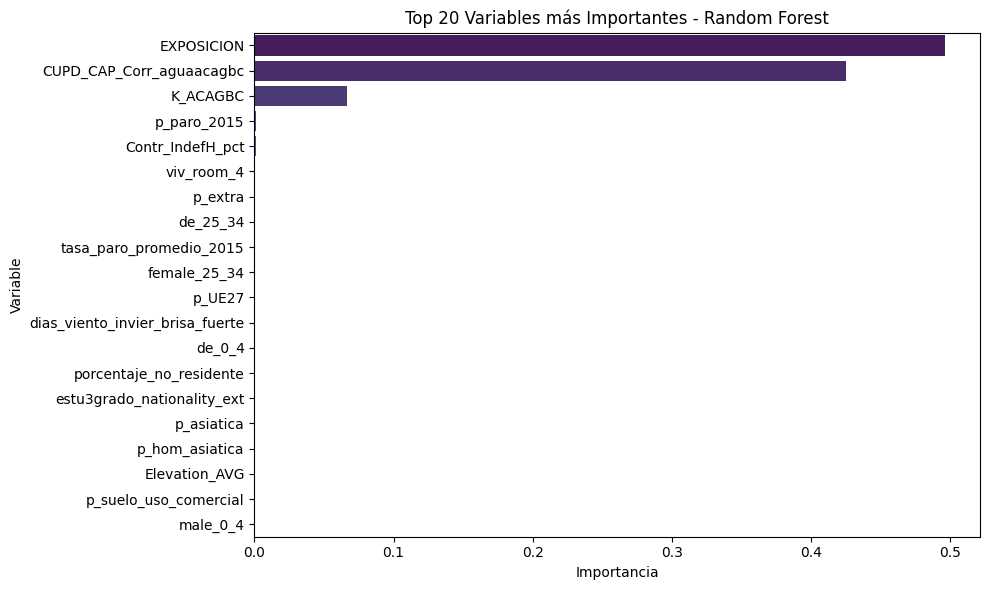

In [18]:
# Importancia de variables 
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df.head(20), x='Importance', y='Feature', palette='viridis')
plt.title('Top 20 Variables más Importantes - Random Forest')
plt.xlabel('Importancia')
plt.ylabel('Variable')
plt.tight_layout()
plt.show()

In [19]:
# MULTICOLINEALIDAD (VIF) SOBRE TOP VARIABLES
top_features = importance_df['Feature'].head(20).tolist()
top_features = [var for var in top_features if var != 'year']
X_selected = X[top_features].copy()
for col in X_selected.columns:
    if X_selected[col].dtype == 'object':
        X_selected[col] = X_selected[col].astype('category').cat.codes
    else:
        X_selected[col] = pd.to_numeric(X_selected[col], errors='coerce')
X_selected = X_selected.replace([np.inf, -np.inf], np.nan).dropna()

vif_df = pd.DataFrame()
vif_df['Variable'] = X_selected.columns
vif_df['VIF'] = [variance_inflation_factor(X_selected.values, i) for i in range(X_selected.shape[1])]
print("\n🔁 VIF:")
print(vif_df.sort_values(by='VIF', ascending=False).head(20))


🔁 VIF:
                           Variable     VIF
7                          de_25_34 1428.89
9                      female_25_34 1363.60
12                           de_0_4  990.24
19                         male_0_4  939.79
3                       p_paro_2015  282.11
8           tasa_paro_promedio_2015  233.97
15                       p_asiatica  176.13
16                   p_hom_asiatica  156.13
6                           p_extra   77.55
10                           p_UE27   60.62
11  dias_viento_invier_brisa_fuerte   22.21
5                        viv_room_4   20.57
18            p_suelo_uso_comercial    6.84
13          porcentaje_no_residente    5.93
14       estu3grado_nationality_ext    3.33
0                        EXPOSICION    3.13
17                    Elevation_AVG    2.48
2                          K_ACAGBC    2.37
4                  Contr_IndefH_pct    1.57
1          CUPD_CAP_Corr_aguaacagbc    1.13


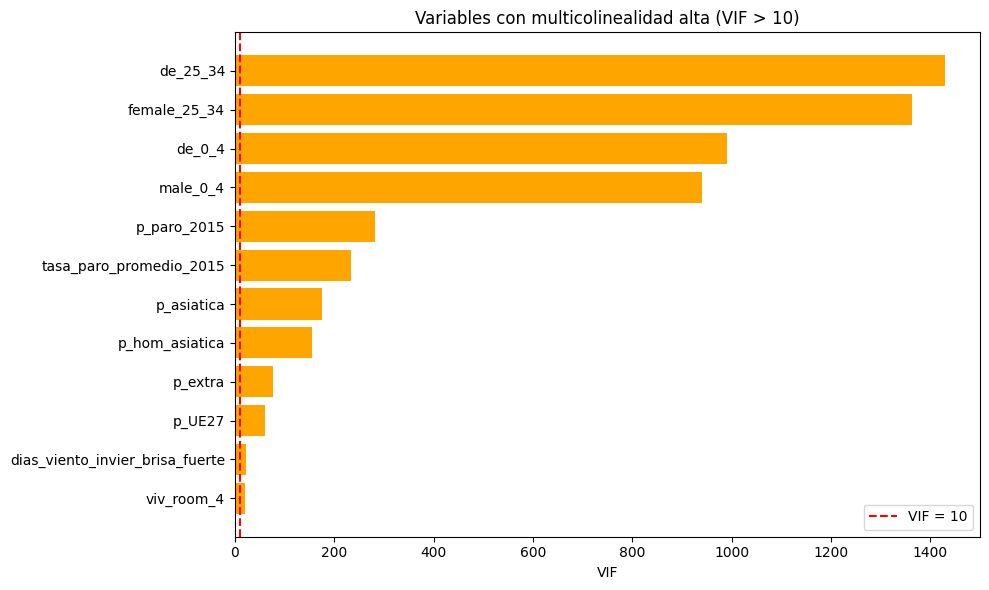

In [20]:
# VIF > 10 ===
vif_altos = vif_df[vif_df['VIF'] > 10].sort_values(by='VIF', ascending=True)
plt.figure(figsize=(10, 6))
plt.barh(vif_altos['Variable'], vif_altos['VIF'], color='orange')
plt.axvline(10, color='red', linestyle='--', label='VIF = 10')
plt.title("Variables con multicolinealidad alta (VIF > 10)")
plt.xlabel("VIF")
plt.legend()
plt.tight_layout()
plt.show()

In [21]:
# MODELO GLM POISSON CON VARIABLES DEPURADAS
# Filtrar variables con VIF <= 10
vif_validas = vif_df[vif_df['VIF'] <= 10]['Variable'].tolist()
X_selected = X[vif_validas].copy()

In [22]:
# Preparar modelo GLM
for col in X_selected.columns:
    if X_selected[col].dtype == 'object':
        X_selected[col] = X_selected[col].astype('category').cat.codes
    else:
        X_selected[col] = pd.to_numeric(X_selected[col], errors='coerce')
X_selected = X_selected.replace([np.inf, -np.inf], np.nan).dropna()

In [23]:
# Recalcular y_model
y_model = y.loc[X_selected.index]
X_glm = sm.add_constant(X_selected)
modelo_vif = GLM(y_model, X_glm, family=families.Poisson()).fit()
print("Modelo GLM (Poisson) con variables sin colinealidad (VIF <= 10):")
print(modelo_vif.summary())
print("\n Evaluación del modelo:")
print(f"AIC: {modelo_vif.aic:.2f}")
print(f"Deviance: {modelo_vif.deviance:.2f}")

Modelo GLM (Poisson) con variables sin colinealidad (VIF <= 10):
                 Generalized Linear Model Regression Results                  
Dep. Variable:             frecuencia   No. Observations:                35077
Model:                            GLM   Df Residuals:                    35068
Model Family:                 Poisson   Df Model:                            8
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.9869e+05
Date:                Sun, 13 Apr 2025   Deviance:                   5.6612e+05
Time:                        07:34:24   Pearson chi2:                 5.00e+09
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------

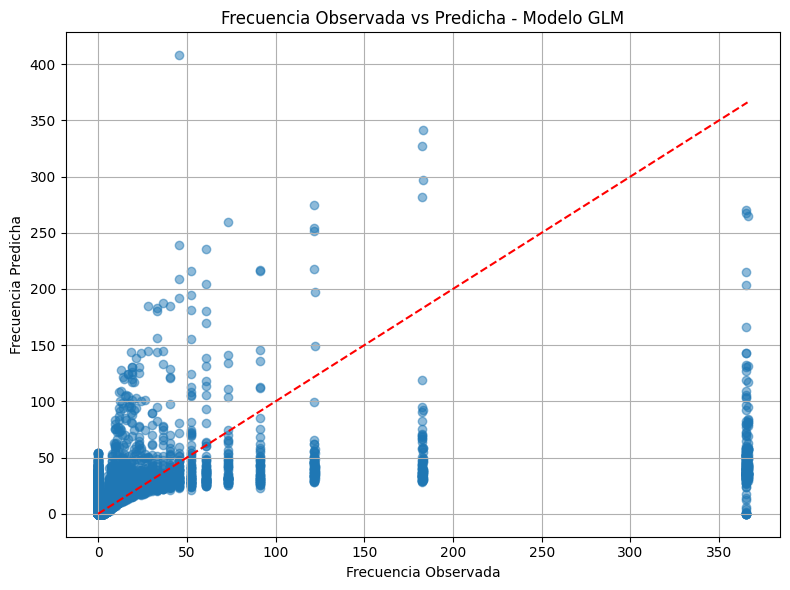

In [24]:
# Ajuste del modelo GLM
y_pred = modelo_vif.predict(X_glm)
plt.figure(figsize=(8, 6))
plt.scatter(y_model, y_pred, alpha=0.5)
plt.plot([y_model.min(), y_model.max()], [y_model.min(), y_model.max()], 'r--')
plt.xlabel('Frecuencia Observada')
plt.ylabel('Frecuencia Predicha')
plt.title('Frecuencia Observada vs Predicha - Modelo GLM')
plt.grid(True)
plt.tight_layout()
plt.show()

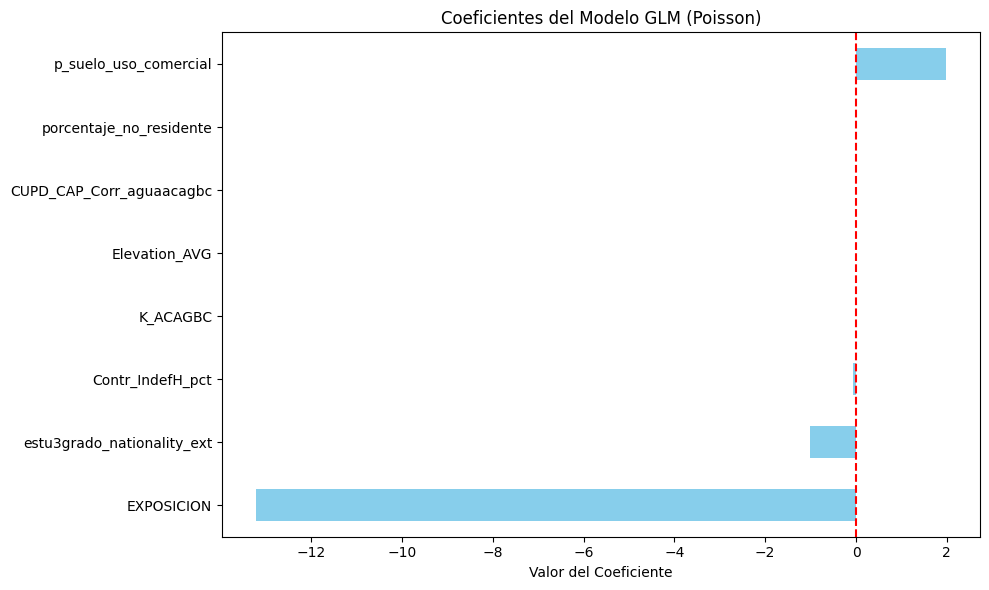

In [25]:
coef_df = modelo_vif.params.drop("const").sort_values()
plt.figure(figsize=(10, 6))
coef_df.plot(kind='barh', color='skyblue')
plt.axvline(0, color='red', linestyle='--')
plt.title("Coeficientes del Modelo GLM (Poisson)")
plt.xlabel("Valor del Coeficiente")
plt.tight_layout()
plt.show()